In [3]:
pip install openseespy

Note: you may need to restart the kernel to use updated packages.


## **Modeling this Turbine**
**65-kW Wind Turbine courtesy of UCSD**
<img src='Research\Turbine.PNG' width="300" height="300">

In [4]:
# following example on http://opensees.berkeley.edu/wiki/index.php/Elastic_Frame_Example
# running dynamic ground motion

%matplotlib notebook

# import OpenSees and libraries
from openseespy.opensees import *
from openseespy.postprocessing.Get_Rendering import *

# numerical and plotting tools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import math
from math import sqrt
import pandas as pd
import csv

# system commands
import os, os.path
import glob
import shutil

In [10]:
def buildmodel(angle):

    # -------------------------------
    #       Generate Model
    # -------------------------------

    # remove existing model
    wipe()

    # remove existing results
    # explanation here: https://stackoverflow.com/a/31989328
    def remove_thing(path):
        if os.path.isdir(path):
            shutil.rmtree(path)
        else:
            os.remove(path)

    def empty_directory(path):
        for i in glob.glob(os.path.join(path, '*')):
            remove_thing(i)

    empty_directory('modes')
    empty_directory('output')

    # ---------------------------------------
    #   Generate model and static analysis
    # ---------------------------------------

    # set modelbuilder
    model('basic', '-ndm', 3, '-ndf', 6)

    # units: in, kip, s
    # dimensions
    ft = 12.0
    inch = 1.0
    g = 386.1 #in/s^2
    kip = 1.0
    ksi = kip/(inch**2)
    s = 1

    # material properties
    Es = 29000*ksi
    Gs = 11500*ksi

    # -------------------------------
    #       Create Nodes
    # -------------------------------
    # command: node(nodeID, x-coord, y-coord, z-coord)
    # command: node(nodeTag, *crds, '-ndf', ndf, '-mass', *mass, '-disp', *disp, '-vel', *vel, '-accel', *accel)
    # Note: Ian Prowell Dissertation: Split into 30 beam-column elements

    # specify number of elements of each portion of the tower
    eldiv = 6

    # Defining the first node
    nodeTag = 1
    node(nodeTag, 0.0, 0.0, 0.0)

    # Heights of tower sections
    hbot = 238.2*inch
    hbottap = 74.8*inch
    hmid = 237.2*inch
    hmidtap = 74.8*inch
    htop = 263*inch # to reach the top of the nacelle 238 og 
    #angle = 5*math.pi/180
    
    # Lower tower section (Split into eldiv elements)
    for j in range(eldiv):
        nodeTag += 1
        h = (hbot/eldiv)*(j + 1)
        node(nodeTag, h*math.sin(angle), 0.0, h*math.cos(angle))

    # Tapered lower section (Split into eldiv elements)
    for j in range(eldiv):
        nodeTag += 1
        h = hbot + (hbottap/eldiv)*(j + 1)
        node(nodeTag, h*math.sin(angle), 0.0, h*math.cos(angle))

    # Middle tower section (Split into eldiv elements)
    for j in range(eldiv):
        nodeTag += 1
        h = hbot + hbottap + (hmid/eldiv)*(j + 1)
        node(nodeTag, h*math.sin(angle), 0.0, h*math.cos(angle))

    # Tapered middle section (Split into eldiv elements)
    for j in range(eldiv):
        nodeTag += 1
        h = hbot + hbottap + hmid + (hmidtap/eldiv)*(j + 1)
        node(nodeTag, h*math.sin(angle), 0.0, h*math.cos(angle))

    # Top tower section (Split into eldiv elements)
    for j in range(eldiv):
        nodeTag += 1
        h = hbot + hbottap + hmid + hmidtap + (htop/eldiv)*(j + 1)
        node(nodeTag, h*math.sin(angle), 0.0, h*math.cos(angle))

    # restraints
    # command: fix(nodeID, DOF1, DOF2, DOF3, DOF4, DOF5, DOF6) 0 = free, 1 = fixed
    # Use a fixed connection for now
    fix(1, 1, 1, 1, 1, 1, 1)

    # geometric transformation for beam-columns
    # command: geomTransf('Type', TransfTag)
    # see https://opensees.berkeley.edu/wiki/index.php/Linear_Transformation 
    geomTransf('PDelta', 1, 0, 1, 0) #columns

    # -------------------------------
    #       Define Elements
    # -------------------------------

    # initialize lists
    D = [] # diameters in
    A = [] # areas in^2
    I = [] # area moment of inertia in^4
    J = [] # polar moment of inertia in^4
    dM = [] # distributed masses kip*s^2/in
    V = [] # volumes in^3
    H = [] # height of each element in
    t = 0.21*inch # thickness is constant


    # Determining the diameters, areas, area moment of inertias, and polar moments of each discretized tower segment
    # diameters of tower
    dbot = 78.7*inch
    dmid = 62.9*inch
    dtop = 47.2*inch

    index = 0

    # Lower tower section (Split into eldiv elemenets)
    for j in range(eldiv):
        H.append(hbot/eldiv)
        D.append(dbot)
        A.append(((D[index])**2 - (D[index] - (2*t))**2)*math.pi/4)
        I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
        J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
        index += 1

    # Tapered lower section (Split into eldiv elements)
    for j in range(eldiv):
        H.append(hbottap/eldiv)
        d = ((j + 1)/(2*eldiv))*(dmid-dbot) + dbot # interpolating for the diameter based on eldiv
        D.append(d)
        A.append(((D[index])**2 - (D[index] - 2*t)**2)*math.pi/4)
        I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
        J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
        index += 1

    # Middle tower section (Split into eldiv elements)
    for j in range(eldiv):
        H.append(hmid/eldiv)
        D.append(dmid)
        A.append(((D[index])**2 - (D[index] - 2*t)**2)*math.pi/4)
        I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
        J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
        index += 1

    # Tapered middle section (Split into eldiv elements)
    for j in range(eldiv):
        H.append(hmidtap/eldiv)
        d = ((j + 1)/(2*eldiv))*(dtop-dmid) + dmid # interpolating for the diameter based on eldiv
        D.append(d)
        A.append(((D[index])**2 - (D[index] - 2*t)**2)*math.pi/4)
        I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
        J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
        index += 1

    # Top tower section
    for j in range(eldiv):
        H.append(htop/eldiv)
        D.append(dtop)
        A.append(((D[index])**2 - (D[index] - 2*t)**2)*math.pi/4)
        I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
        J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
        index += 1

    # Determining volumes of tower segments
    index = 0

    # Lower tower section (Split into eldiv elemenets)
    for j in range(eldiv):
        v = math.pi*(hbot/eldiv)*(D[index]**2 - (D[index]-2*t)**2)/4
        V.append(v)
        index += 1

    # Tapered lower section (Split into eldiv elements)
    for j in range(eldiv):
        dlower = ((dmid-dbot)*j)/(eldiv) + dbot
        dhigher = ((dmid-dbot)*(j+1))/(eldiv) + dbot
        v = math.pi*(hbottap/eldiv)*((dlower**2 +dlower*dhigher + dhigher**2)-((dlower-2*t)**2 + (dlower-2*t)*(dhigher-2*t) + (dhigher-2*t)**2))/12
        V.append(v)
        index += 1    

    # Middle tower section (Split into eldiv elements)
    for j in range(eldiv):
        v = math.pi*(hmid/eldiv)*(D[index]**2 - (D[index]-2*t)**2)/4
        V.append(v)
        index += 1

    # Tapered middle section (Split into eldiv elements)
    for j in range(eldiv):
        dlower = ((dtop-dmid)*j)/(eldiv) + dmid
        dhigher = ((dtop-dmid)*(j+1))/(eldiv) + dmid
        v = math.pi*(hmidtap/eldiv)*((dlower**2 +dlower*dhigher + dhigher**2)-((dlower-2*t)**2 +(dlower-2*t)*(dhigher-2*t) + (dhigher-2*t)**2))/12
        V.append(v)
        index += 1    

    # Top tower section (Split into eldiv elements)
    for j in range(eldiv):
        v = math.pi*(htop/eldiv)*(D[index]**2 - (D[index]-2*t)**2)/4
        V.append(v)
        index += 1


    mtotal = 14.101*kip/g
    vtotal = sum(V)
    htotal = hbot + hbottap + hmid + hmidtap + htop

    # Determining distributed masses of tower segments
    # Entire tower section (Split into 5*eldiv elemenets)
    for j in range(len(H)):
        distm = (mtotal*V[j])/(vtotal*H[j]) # mass/height constant
        dM.append(distm)

    # Defining the elements and determining areas, area moment of inertias, and polar inertias for each section
    # Cylindrical sections => Ix = Iy 
    # Cylindrical sections => J = Iz = 2*Ix = (D^4-(D-t)^4)*(pi/32) 

    # Assigning element properties
    # create elastic beam-column elements - 
    # command: element('elasticBeamColumn', eleTag, *eleNodes, Area, E_mod, G_mod, Jxx, Iy, Iz, transfTag, <'-mass', mass>, <'-cMass'>)
    # define the columns  
    for j in range(len(H)):
        element('elasticBeamColumn', j+1, j+1, j+2, A[j], Es, Gs, J[j], I[j], I[j], 1, '-mass', dM[j])

    # Uncomment to see how the turbine twists
    #node(nodeTag +1, 0.0, 10.0*ft, h)
    #geomTransf('Linear', 2, 0, 0, 1) #columns
    #element('elasticBeamColumn', len(H) + 1, len(H) + 1, len(H) + 2, A[len(H)-2], Es, Gs, J[len(H)-2], I[len(H)-2], I[len(H)-2], 2, '-mass', dM[len(H)-2])

    # assign additional masses
    # masses only act at nodes that have DoF
    # command: mass(nodeID, dx, dy, dz, r@x, r@y, r@z)
    # rotational inertia for a point mass: I = mr^2
    whub = 9.4*kip
    mhub = whub/g #kip*s^2/in
    ### to-do: the box is slightly higher than the last node of the tower, should we add another node? how would it be connected to the rest of the tower?
    hhub = 888*inch # height of hub
    #node(len(H) + 2, 0.0, 0.0, hhub) # CHANGE the top height it this is used
    #rigidLink('beam', len(H)+1, len(H)+2)
    mass(len(H) + 1, mhub, mhub, mhub, 0.0, 0.0, 0.0)

Natural Frequencies: [1.7416607571903033, 1.7416607571903038, 12.93161742132173, 12.931617421321738, 31.418375759311445, 37.50532816108513, 37.505328161085586, 79.97732298602298, 79.9773229860237, 104.63755980265053, 133.17346388794977, 133.17346388795, 196.81607870835407, 203.02975758995674, 203.0297575899582, 286.65036811997516, 286.65036811997567, 292.1269359117963, 381.99054626341984, 386.73682930268654, 386.73682930268683, 472.3499565287922, 503.8193891083715, 503.81938910837215, 568.2869993159867, 623.540185646824, 623.5401856468254, 648.9158433117032, 729.0586013039622, 766.5852489920486] Hz
No Model_ODB specified, trying to get data from the active model.
3D model


<IPython.core.display.Javascript object>


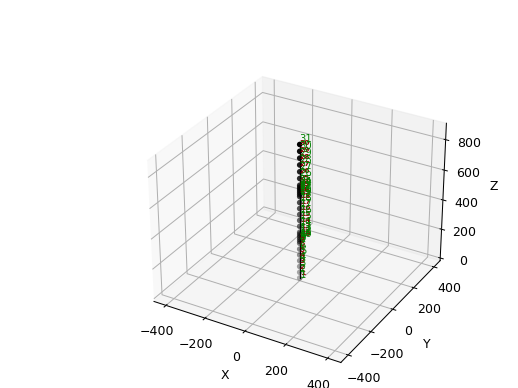

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>


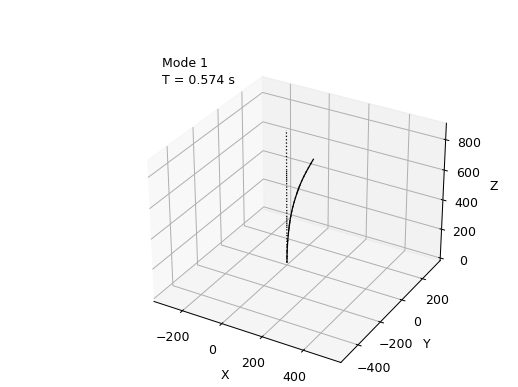

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>


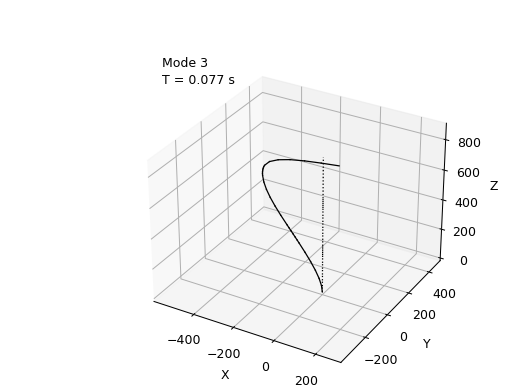

No Model_ODB specified to plot modeshapes
3D model


<IPython.core.display.Javascript object>


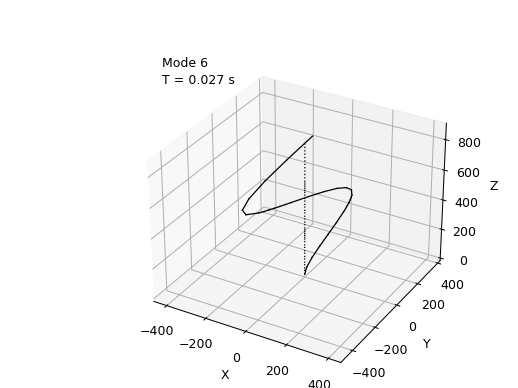

Rx = -7.815970093361102e-14
Ry = 0.0
Rz = 452.17598604294835
Mx = 0.0
My = 0.0
Mz = 0.0


In [12]:
# units: in, kip, s
# dimensions
ft = 12.0
inch = 1.0
g = 386.1 #in/s^2
kip = 1.0
ksi = kip/(inch**2)
s = 1

buildmodel(0*math.pi/180) # Build model to determine natural frequency
# --------------------------------
#       Perform eigen analysis
# --------------------------------

numEigen = 30
lameigenValues = eigen(numEigen)

wn = [i ** 0.5 for i in lameigenValues]
fn = [i / (2*math.pi) for i in wn]

print("Natural Frequencies:", fn, "Hz")

# compute the modal properties
#modalProperties("-print", "-file", "ModalReport.txt", "-unorm")

# -------------------------------------------
#       Plotting Structure and Modeshapes
# -------------------------------------------

# Display the active model with node and element tags
plot_model("nodes","elements")

plot_modeshape(1, 50)
plot_modeshape(3, 50)
plot_modeshape(6, 50)

# set the rayleigh damping factors for nodes & elements
rayleigh(0.0, 0.0, 0.0, 2*0.005/wn[0])


# -------------------------------
#       Set up Static analysis
# -------------------------------
# create TimeSeries 
timeSeries("Linear", 1)

# create plain load pattern
# command pattern('Plain', tag, timeSeriesTag)


pattern('Plain', 1, 1)
index = 0

# Lower tower section (Split into eldiv elemenets)
dM = [5.1830448444470526e-05, 5.1830448444470526e-05, 5.1830448444470526e-05, 5.1830448444470526e-05, 5.1830448444470526e-05, 5.1830448444470526e-05, 5.0960994707877264e-05, 4.9222087234690734e-05, 4.7483179761504204e-05, 4.5744272288316725e-05, 4.4005364815130195e-05, 4.2266457341942717e-05, 4.139700360534957e-05, 4.139700360534957e-05, 4.139700360534957e-05, 4.139700360534957e-05, 4.139700360534957e-05, 4.139700360534957e-05, 4.053305274050647e-05, 3.8805151010820987e-05, 3.7077249281135025e-05, 3.534934755144907e-05, 3.362144582176382e-05, 3.189354409207785e-05, 3.102959322723487e-05, 3.102959322723487e-05, 3.102959322723487e-05, 3.102959322723487e-05, 3.102959322723487e-05, 3.102959322723487e-05]
H = [39.699999999999996, 39.699999999999996, 39.699999999999996, 39.699999999999996, 39.699999999999996, 39.699999999999996, 12.466666666666667, 12.466666666666667, 12.466666666666667, 12.466666666666667, 12.466666666666667, 12.466666666666667, 39.53333333333333, 39.53333333333333, 39.53333333333333, 39.53333333333333, 39.53333333333333, 39.53333333333333, 12.466666666666667, 12.466666666666667, 12.466666666666667, 12.466666666666667, 12.466666666666667, 12.466666666666667, 43.833333333333336, 43.833333333333336, 43.833333333333336, 43.833333333333336, 43.833333333333336, 43.833333333333336]

for j in range(29):
    index += 1
    eleLoad('-ele', index, '-type', '-beamUniform', 0, 0, -dM[index]*H[index]*g, 0,0,0)


# ------------------------------
# Start of analysis generation
# ------------------------------

# create system of equation (SOE)
system("BandSPD")
# create DOF numberer
numberer("RCM")
# create constraint handler
constraints("Plain")
# create integration scheme (steps of 1.0)
integrator("LoadControl", 1.0)
# create solution algorithm
algorithm("Linear")
# create analysis object
analysis("Static")
# perform the analysis
analyze(1)

reactions() # call before nodeReaction
node1Rx = nodeReaction(2, 1)
node1Ry = nodeReaction(1, 2)
node1Rz = nodeReaction(1, 3)
node1Mx = nodeReaction(1, 4)
node1My = nodeReaction(1, 5)
node1Mz = nodeReaction(1, 6)

print('Rx =', node1Rxn)
print('Ry =', node1Ryn)
print('Rz =', node1Rzn)
print('Mx =', node1Mx)
print('My =', node1My)
print('Mz =', node1Mz)


In [10]:
# units: in, kip, s
# dimensions
ft = 12.0
inch = 1.0
g = 386.1 #in/s^2
kip = 1.0
ksi = kip/(inch**2)
s = 1

# ----------------------------------
#       Define Sinusoidal Loading
# ----------------------------------

# Define parameters of the Sinusoidal Loading

T = 30 #Define how long the loading should go for
dt = 0.001 # Define the time step for input ground motion
tsteps = range(int((T/dt)))

t = [] # Define time list
for i in (tsteps):
    t.append(dt*i)

    
# Wave typical frequency and magnitude
# Define range of forcing frequency f (Hz)
f1 = 0.01/s
f2 = 0.1/s
df = 0.01 # Define discretization of forcing frequencies 
fsteps = range(int((f2-f1)/df))

# Wind typical frequency and magnitude
# # Define range of forcing frequency f (Hz)
# f1 = 0.05/s
# f2 = 2/s
# df = 0.1 # Define discretization of forcing frequencies 
# fsteps = range(int((f2-f1)/df))

# Blade typical frequency and magnitude
# # Define range of forcing frequency f (Hz)
# f1 = 0.5/s
# f2 = 2/s
# df = 0.1 # Define discretization of forcing frequencies 
# fsteps = range(int((f2-f1)/df))


# -------------------------------
#       Set up Dynamic analysis
# -------------------------------
f = []
peakVx = []
peakVy = []
peakMx = []
peakMy = []
dfVx = pd.DataFrame(index=[t]) # Define dataframe with all Base Shear x data
dfVy = pd.DataFrame(index=[t]) # Define dataframe with all Base Shear y data
dfMx = pd.DataFrame(index=[t]) # Define dataframe with all Overturning Moment about the x axis data
dfMy = pd.DataFrame(index=[t]) # Define dataframe with all Overturning Moment about the y axis data

# # Define a function to return the maximum value of the steady state response
# def eleMax(items, start = 0, end=None):
#     return abs(max(items[start:end], key=abs))

buildmodel() # Build model to determine natural frequency
# --------------------------------
#       Perform eigen analysis
# --------------------------------

numEigen = 30
lameigenValues = eigen(numEigen)

wn = [i ** 0.5 for i in lameigenValues]
fn = [i / (2*math.pi) for i in wn]

print("Natural Frequencies:", fn, "Hz")

# compute the modal properties
#modalProperties("-print", "-file", "ModalReport.txt", "-unorm")

# -------------------------------------------
#       Plotting Structure and Modeshapes
# -------------------------------------------

# Display the active model with node and element tags
#plot_model("nodes","elements")

#plot_modeshape(1, 50)
#plot_modeshape(3, 50)
#plot_modeshape(6, 50)


# set the rayleigh damping factors for nodes & elements
rayleigh(0.0, 0.0, 0.0, 2*0.005/wn[0])

# Looping for each frequency
for i in fsteps:
    buildmodel() # Wipe and build new model for every frequency
    wipeAnalysis() # Wipe any previous pattern
    constraints('Plain')  			# how it handles boundary conditions
    numberer('Plain')
    system('BandGeneral')		    # how to store and solve the system of equations in the analysis
    algorithm('Newton')                 # use Newton-Raphson for linear analysis
    integrator('Newmark', 0.5, 0.25)        # create integration scheme, Newmark with alpha = 0.5, beta = 0.25
    analysis('Transient')      	    # define type of analysis static or transient

    # Create the convergence test, the norm of the residual with a tolerance of
    # 1e-12 and a max number of iterations of 10
    test('NormDispIncr', 1.0e-12,  10 )

# # # Run each ground motion per each frequency wf and extract the maximum moment per each sinusoidal ground motion
    f.append(f1 + (df*i)) # Keeping track of the frequencies
    Vx = [] # Resetting each vector for each frequency
    Vy = []
    Mx = []
    My = []
    setTime(0) # Reset time
    time = []
    
    # Setting up variables for the transient analysis
    tCurrent = getTime()
    tFinal = T
    ok = 0
    # Getting the correct ground motion per frequency step
    timeSeries('Trig', i+1, 0, T, 1/f[i], '-factor', g*0.7255) 
    # patternTag, direction  accelTag
    pattern('UniformExcitation', i+1, 1, '-accel', i+1) # x direction

    # Perform the transient analysis
    while ok == 0 and tCurrent < tFinal:
        ok = analyze(1, dt)
        if ok != 0:
            print('WARNING' + str(tCurrent) + 'w' + str(i))
        # if the analysis fails try initial tangent iteration
            print("regular newton failed .. let's try an initial stiffness for this step")
            test('NormDispIncr', 1.0e-12,  100, 0)
            algorithm('ModifiedNewton', '-initial')
            ok = analyze(1, dt)
            if ok == 0:
                print("that worked .. back to regular newton")
            test('NormDispIncr', 1.0e-12,  10 )
            algorithm('Newton')
        # Store element forces per time step 
        tCurrent = getTime()
        time.append(tCurrent)     
        Vx.append(eleForce(1, 1)) # Vx
        Vy.append(eleForce(1, 2)) # Vy
        Mx.append(eleForce(1, 4)) # Mx
        My.append(eleForce(1, 5)) # My
    # Post-processing
    #maxVx = eleMax(Vx, int((T/dt)+1) - 20)
    #peakVx.append(maxVx)
    peakVx.append(abs(max(Vx, key=abs)))
    peakVy.append(abs(max(Vy, key=abs)))
    peakMx.append(abs(max(Mx, key=abs)))
    peakMy.append(abs(max(My, key=abs)))
    dfVx['w'+str(i)+"="+str(f[i])] = Vx
    dfVy['w'+str(i)+"="+str(f[i])] = Vy
    dfMx['w'+str(i)+"="+str(f[i])] = Mx
    dfMy['w'+str(i)+"="+str(f[i])] = My
    
dfVx.head(20)


Natural Frequencies: [3.8585364796445383, 3.8585364796445387, 17.93121957877976, 17.931219578779768, 45.14683267209806, 45.14683267209812, 54.948995521167404, 90.331176292591, 90.3311762925912, 144.87793222270503, 146.73934286775824, 146.73934286775855, 217.55357484221193, 217.55357484221338, 232.9887810592705, 303.9778727088689, 303.9778727088851, 339.26547434050815, 402.8693447618272, 402.86934476183035, 428.3551850388825, 511.0369740654836, 521.3346189956037, 521.3346189956209, 610.6208304907256, 638.8713188063649, 638.8713188063723, 694.2962668000305, 765.5910987171005, 779.7665605035276] Hz


,w0=0.01,w1=0.02,w2=0.03,w3=0.04,w4=0.05,w5=0.060000000000000005,w6=0.06999999999999999,w7=0.08,w8=0.09
0.000,0.000063,0.000125,0.000188,0.000251,0.000314,0.000376,0.000439,0.000502,0.000565
0.001,0.000188,0.000376,0.000564,0.000752,0.000940,0.001128,0.001316,0.001504,0.001692
0.002,0.000345,0.000690,0.001034,0.001379,0.001724,0.002069,0.002413,0.002758,0.003103
0.003,0.000532,0.001064,0.001595,0.002127,0.002659,0.003191,0.003722,0.004254,0.004786
0.004,0.000740,0.001480,0.002220,0.002960,0.003700,0.004440,0.005180,0.005920,0.006660
0.005,0.000966,0.001933,0.002899,0.003866,0.004832,0.005798,0.006765,0.007731,0.008697
0.006,0.001210,0.002420,0.003631,0.004841,0.006051,0.007261,0.008471,0.009682,0.010892
0.007,0.001471,0.002942,0.004413,0.005884,0.007355,0.008827,0.010298,0.011769,0.013240
0.008,0.001747,0.003494,0.005242,0.006989,0.008736,0.010483,0.012230,0.013977,0.015725
0.009,0.002037,0.004075,0.006112,0.008149,0.010187,0.012224,0.014261,0.016299,0.018336


<IPython.core.display.Javascript object>


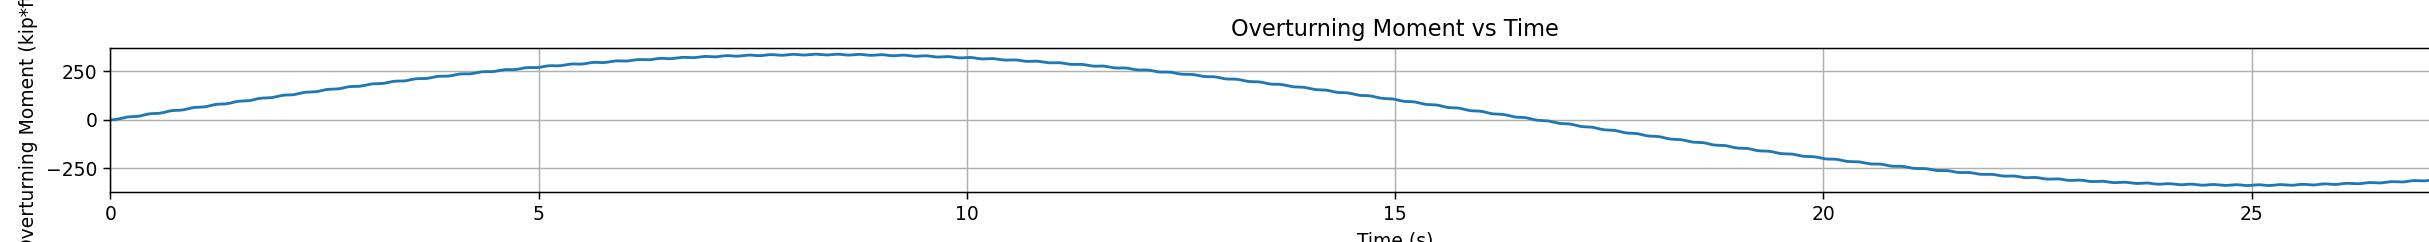

(0.0, 30.0)

In [20]:


#plt.plot(time, dfVx['w1'])
# dfMy.head(30)

#fig, ax = plt.subplots(dpi = 200, figsize=(20,3)) #time
fig, ax = plt.subplots(dpi = 150, figsize=(20,2)) #freq


# plt.plot(time, dfVx.iloc[:,50])
# plt.ylabel('Base Shear (kip)')
# plt.xlabel('Time (s)')
# plt.title('Base Shear vs Time')
# plt.grid(b=True)
# plt.show()

ax.plot(time, dfMy.iloc[:,2]/12)
ax.set_ylabel('Overturning Moment (kip*ft)')
ax.set_xlabel('Time (s)')
ax.set_title('Overturning Moment vs Time')
ax.grid(True)
plt.tight_layout()
plt.xlim([0,T])

# ax.plot(f, peakVx)
# ax.set_ylabel('Peak Base Shear (kip)')
# ax.set_xlabel('Forcing Frequency (Hz)')
# ax.set_title('Peak Base Shear vs Forcing Frequency')
# ax.grid(True)
# plt.tight_layout()
# plt.xlim([0,f2])


# plt.plot(f, peakVx)
# plt.ylabel('Peak Base Shear (kip)')
# plt.xlabel('Frequency (Hz)');


In [18]:


# print(f)
# print(peakVx)
# print(peakMy)
# print(f2)
a = []
b = []
x = range(50)
for i in x:
    a.append(0)
    b.append(0.49+(i*0.01))
print(a)
print(b)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.6699999999999999, 0.6799999999999999, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.8200000000000001, 0.8300000000000001, 0.8400000000000001, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.9099999999999999, 0.9199999999999999, 0.9299999999999999, 0.94, 0.95, 0.96, 0.97, 0.98]


In [ ]:
# 3-D Plotting

#https://stackoverflow.com/questions/51765184/how-to-3d-plot-function-of-2-variables-in-python?noredirect=1&lq=1
#https://stackoverflow.com/questions/45396059/multiple-independent-lines-in-the-same-3d-axes
fig = plt.figure()
ax = fig.gca(projection='3d')

freq = pd.DataFrame(index=[t])

for i in range(20): # all frequencies: len(f)
    freq[i] =  [f[i]] * len(time)
    ax.plot(time,freq[i], dfVx.iloc[:,i])
    

# make labels
ax.set_xlabel('Time (s)')
ax.set_ylabel('Forcing Frequency (Hz)')
ax.set_zlabel('Base Shear (kip)')

plt.show()

In [ ]:
# 3-D Plotting Surface

#https://stackoverflow.com/questions/12423601/simplest-way-to-plot-3d-surface-given-3d-points
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
import numpy
from numpy.random import randn
from scipy import array, newaxis

Vx3dall = []
Vx3d = []

for i in range(200): #len(f)
    for j in range(20000): #len(time)
        Vx3d = [time[j], f[i], dfVx.iat[j,i]]
        Vx3dall.append(Vx3d)

DATA = array(Vx3dall)
Xs = DATA[:,0]
Ys = DATA[:,1]
Zs = DATA[:,2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(Xs, Ys, Zs, cmap=cm.jet, linewidth=0)
fig.colorbar(surf)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

# make labels
ax.set_xlabel('Time (s)')
ax.set_ylabel('Forcing Frequency (Hz)')
ax.set_zlabel('Base Shear (kip)')

fig.tight_layout()

plt.show()
